In [59]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import io

In [60]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# Upload data csv ke Google Colab dari local drive

In [61]:
from google.colab import files
student_por = files.upload()

Saving student-por.csv to student-por (2).csv


# Buat dataframe

In [62]:
df_student_por = pd.read_csv(io.BytesIO(student_por['student-por.csv']))

# Ekspansi kolom yang bersifat text/string

In [63]:
encoded_por = pd.get_dummies(df_student_por, columns=['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic'])

In [64]:
encoded_por.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,1,3,4,0,11,11,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,1,3,2,9,11,11,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,3,3,6,12,13,12,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,1,5,0,14,14,14,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,2,5,0,11,13,13,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0


# Pisahkan data train dan test (80/20)

In [84]:
train_dataset = encoded_por.sample(frac=0.8, random_state=0)
test_dataset = encoded_por.drop(train_dataset.index)

# Pisahkan kolom Dalc dan Walc sebagai label

In [85]:
train_labels_dalc = train_dataset.pop('Dalc')
test_labels_dalc = test_dataset.pop('Dalc')

train_labels_walc = train_dataset.pop('Walc')
test_labels_walc = test_dataset.pop('Walc')

# Drop kolom Dalc dan Walc dari features

In [86]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

In [87]:
train_features

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,G1,G2,G3,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
532,16,2,1,2,2,0,4,2,2,5,2,9,7,8,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1
375,17,0,2,2,3,0,3,3,3,2,0,14,14,15,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0
306,18,3,4,2,2,0,4,2,5,1,6,15,16,16,1,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0
625,18,2,3,2,1,0,5,2,3,4,0,10,10,10,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1
480,19,2,3,1,1,1,4,4,4,2,0,9,9,10,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,15,2,2,1,4,0,5,5,4,5,6,14,13,13,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0
507,17,1,1,1,3,0,4,3,3,3,0,11,11,10,0,1,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,0,1
228,17,4,4,1,1,0,5,2,1,3,6,12,11,11,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0
445,15,1,1,4,2,0,5,4,5,4,8,7,9,9,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,0,1


# Normalization, preprocessing

In [88]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
age,16.789981,1.236594
Medu,2.527938,1.124786
Fedu,2.290944,1.091444
traveltime,1.587669,0.755624
studytime,1.938343,0.822027
failures,0.231214,0.602848
famrel,3.915222,0.986658
freetime,3.165703,1.052437
goout,3.173410,1.184189
health,3.477842,1.448935


In [89]:
normalizer = preprocessing.Normalization()

In [90]:
normalizer.adapt(np.array(train_features))

# DNN Model

In [91]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [92]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 57)                115       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                3712      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 8,052
Trainable params: 7,937
Non-trainable params: 115
_________________________________________________________________


In [93]:
%%time
history = dnn_model.fit(
    train_features, train_labels_dalc,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 5.06 s, sys: 282 ms, total: 5.34 s
Wall time: 4.69 s


In [94]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.070662,0.702143,95
96,0.061468,0.698430,96
97,0.059208,0.698831,97
98,0.069390,0.701356,98
99,0.067295,0.687789,99


In [95]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Dalc]')
  plt.legend()
  plt.grid(True)

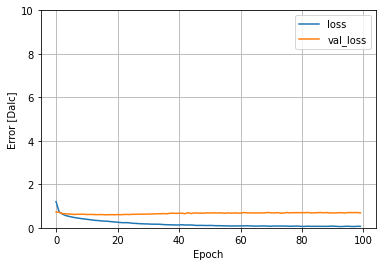

In [96]:
plot_loss(history)

In [97]:
test_results = {}

test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels_dalc, verbose=0)

In [98]:
pd.DataFrame(test_results, index=['Mean absolute error [Dalc]']).T

,Mean absolute error [Dalc]
dnn_model,0.639016


# Prediction

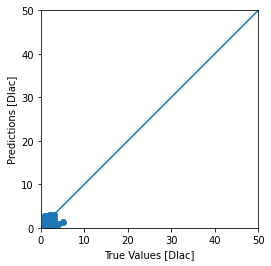

In [99]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels_dalc, test_predictions)
plt.xlabel('True Values [Dlac]')
plt.ylabel('Predictions [Dlac]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

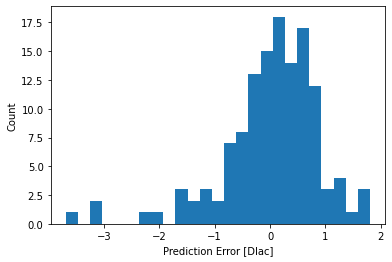

In [100]:
error = test_predictions - test_labels_dalc
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Dlac]')
_ = plt.ylabel('Count')

In [101]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [102]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels_dalc, verbose=0)

In [103]:
pd.DataFrame(test_results, index=['Mean absolute error [Dlac]']).T

,Mean absolute error [Dlac]
dnn_model,0.639016
reloaded,0.639016
